<a href="https://colab.research.google.com/github/andrewpark19/4thyear-FYP/blob/main/resnet50_cnn_binary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Mon Jun 20 21:57:12 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 14.8 MB/s 


In [3]:
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import matplotlib.pyplot as plt
from tensorflow.keras import layers
import tensorflow_addons as tfa
from sklearn.model_selection import train_test_split

In [4]:
!unzip /content/drive/MyDrive/melanoma_data/isic_2020/train_2020/train_2020.zip > /dev/null
!unzip /content/drive/MyDrive/melanoma_data/isic_2020/test_2020/test_2020.zip > /dev/null
!unzip /content/drive/MyDrive/melanoma_data/isic_2019/train_2019/train_2019.zip > /dev/null


In [5]:
train2020_dir = '/content/train_2020'
test2020_dir = '/content/test_2020'
train2019_dir = '/content/train_2019' 
data_dir = '/content/drive/MyDrive/melanoma_data'

def get_df(data_dir, train2020_dir, test2020_dir, train2019_dir, use_meta=False):

    ###Training Data
    #2020 Data
    df_train = pd.read_csv(os.path.join(data_dir, r'isic_2020','train_2020.csv')) #path to train_2020.csv
    df_train['filepath'] = df_train['image_name'].apply(lambda x: os.path.join(train2020_dir, f'{x}.jpg'))

    # #2019 data
    df_train2 = pd.read_csv(os.path.join(data_dir, r'isic_2019', 'train_2019.csv')) #path to train_2019.csv
    df_train2['filepath'] = df_train2['image_name'].apply(lambda x: os.path.join(train2019_dir, f'{x}.jpg'))

    # #Change Labels to match
    df_train['diagnosis']  = df_train['diagnosis'].apply(lambda x: x.replace('seborrheic keratosis', 'BKL'))
    df_train['diagnosis']  = df_train['diagnosis'].apply(lambda x: x.replace('lichenoid keratosis', 'BKL'))
    df_train['diagnosis']  = df_train['diagnosis'].apply(lambda x: x.replace('solar lentigo', 'BKL'))
    df_train['diagnosis']  = df_train['diagnosis'].apply(lambda x: x.replace('lentigo NOS', 'BKL'))
    df_train['diagnosis']  = df_train['diagnosis'].apply(lambda x: x.replace('cafe-au-lait macule', 'unknown'))
    df_train['diagnosis']  = df_train['diagnosis'].apply(lambda x: x.replace('atypical melanocytic proliferation', 'unknown'))

    df_train2['diagnosis'] = df_train2['diagnosis'].apply(lambda x: x.replace('NV', 'nevus'))
    df_train2['diagnosis'] = df_train2['diagnosis'].apply(lambda x: x.replace('MEL', 'melanoma'))

    df_train = pd.concat([df_train, df_train2]).reset_index(drop=True)

    # ###Test Data
    df_test = pd.read_csv(os.path.join(data_dir,r'isic_2020', 'test_2020.csv'))
    df_test['filepath'] = df_test['image_name'].apply(lambda x: os.path.join(test2020_dir, f'{x}.jpg'))

    if use_meta:
        df_train, df_test, meta_features, n_meta_features = get_meta_data(df_train, df_test)
    else:
        meta_features = None
        n_meta_features = 0

    diagnosis2idx = {d: idx for idx, d in enumerate(sorted(df_train.diagnosis.unique()))}
    df_train['target'] = df_train['diagnosis'].map(diagnosis2idx)
    mel_idx = diagnosis2idx['melanoma']

    df_train, df_val = train_test_split(df_train, test_size=0.25, stratify = df_train[['diagnosis']])

    return df_train, df_val, df_test, meta_features, n_meta_features, mel_idx
  

df_train, df_val, df_test, _, _, mel_idx = get_df(data_dir, train2020_dir, test2020_dir, train2019_dir, use_meta=False)

In [6]:
df_train.loc[df_train.diagnosis == 'BCC', 'benign_malignant'] = 'malignant' 
df_train.loc[df_train.diagnosis == 'SCC', 'benign_malignant'] = 'malignant' 

In [7]:
SEED = 42

num_classes = 2
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 64
patience= 30
num_epochs = 100

image_size= 224

In [8]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(horizontal_flip=True,
                                   vertical_flip=False,
                                   rescale=1/255.0,
                                  #  rotation_range = 90,
                                  #  brightness_range=[0.2,1.0],
                                  #  zoom_range=[0.5,1.0],
                                  #preprocessing_function=keras.applications.resnet50.preprocess_input
                                   )

train_generator = train_datagen.flow_from_dataframe(     
    dataframe=df_train,  
    directory=None,
    x_col='filepath', # name of col in data frame that contains file names
    y_col="benign_malignant", # name of col with labels 
    batch_size=batch_size,
    shuffle=True,
    #save_to_dir=saveDir,
    target_size=(image_size, image_size),
    color_mode='rgb',
    class_mode='sparse'
)

valid_generator = train_datagen.flow_from_dataframe(     
    dataframe=df_val,  
    directory=None,
    x_col='filepath', # name of col in data frame that contains file names
    y_col="benign_malignant", # name of col with labels 
    batch_size=batch_size,
    shuffle=True,
    #save_to_dir=saveDir,
    target_size=(image_size, image_size),
    color_mode='rgb',
    class_mode='sparse'
)

Found 32227 validated image filenames belonging to 2 classes.
Found 10770 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 11615 invalid image filename(s) in x_col="filepath". These filename(s) will be ignored.
  .format(n_invalid, x_col)
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 3845 invalid image filename(s) in x_col="filepath". These filename(s) will be ignored.
  .format(n_invalid, x_col)


In [9]:
#Transfer Learning

base_model = keras.applications.ResNet50(
    weights=None,  
    input_shape=(image_size, image_size, 3),
    include_top=False)

i=0
for layer in base_model.layers:
    layer.trainable = True
    i = i+1
    print(i,layer.name)

inputs = keras.Input(shape=(image_size, image_size, 3))
x = base_model(inputs, training=True)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)
# ADD a fully-connected layer
x = keras.layers.Dense(1024, activation='relu')(x)
# Softmax Layer
outputs = keras.layers.Dense(2, activation='sigmoid')(x)
model = keras.Model(inputs, outputs)

1 input_1
2 conv1_pad
3 conv1_conv
4 conv1_bn
5 conv1_relu
6 pool1_pad
7 pool1_pool
8 conv2_block1_1_conv
9 conv2_block1_1_bn
10 conv2_block1_1_relu
11 conv2_block1_2_conv
12 conv2_block1_2_bn
13 conv2_block1_2_relu
14 conv2_block1_0_conv
15 conv2_block1_3_conv
16 conv2_block1_0_bn
17 conv2_block1_3_bn
18 conv2_block1_add
19 conv2_block1_out
20 conv2_block2_1_conv
21 conv2_block2_1_bn
22 conv2_block2_1_relu
23 conv2_block2_2_conv
24 conv2_block2_2_bn
25 conv2_block2_2_relu
26 conv2_block2_3_conv
27 conv2_block2_3_bn
28 conv2_block2_add
29 conv2_block2_out
30 conv2_block3_1_conv
31 conv2_block3_1_bn
32 conv2_block3_1_relu
33 conv2_block3_2_conv
34 conv2_block3_2_bn
35 conv2_block3_2_relu
36 conv2_block3_3_conv
37 conv2_block3_3_bn
38 conv2_block3_add
39 conv2_block3_out
40 conv3_block1_1_conv
41 conv3_block1_1_bn
42 conv3_block1_1_relu
43 conv3_block1_2_conv
44 conv3_block1_2_bn
45 conv3_block1_2_relu
46 conv3_block1_0_conv
47 conv3_block1_3_conv
48 conv3_block1_0_bn
49 conv3_block1_3_b

Epoch 1/100
504/504 [==============================] - 284s 521ms/step - loss: 0.6043 - accuracy: 0.6754 - top-3-accuracy: 1.0000 - val_loss: 0.5599 - val_accuracy: 0.6511 - val_top-3-accuracy: 1.0000
Epoch 2/100
504/504 [==============================] - 254s 495ms/step - loss: 0.4845 - accuracy: 0.7124 - top-3-accuracy: 1.0000 - val_loss: 0.5215 - val_accuracy: 0.6293 - val_top-3-accuracy: 1.0000
Epoch 3/100
504/504 [==============================] - 249s 488ms/step - loss: 0.4706 - accuracy: 0.7162 - top-3-accuracy: 1.0000 - val_loss: 0.4847 - val_accuracy: 0.7218 - val_top-3-accuracy: 1.0000
Epoch 4/100
504/504 [==============================] - 275s 542ms/step - loss: 0.4603 - accuracy: 0.7295 - top-3-accuracy: 1.0000 - val_loss: 0.7388 - val_accuracy: 0.5858 - val_top-3-accuracy: 1.0000
Epoch 5/100
504/504 [==============================] - 246s 484ms/step - loss: 0.4500 - accuracy: 0.7303 - top-3-accuracy: 1.0000 - val_loss: 0.5781 - val_accuracy: 0.6433 - val_top-3-accuracy: 1.

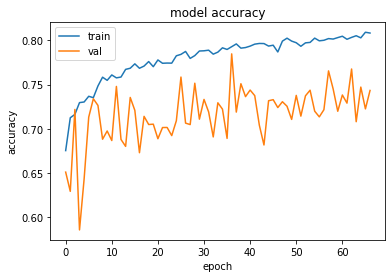

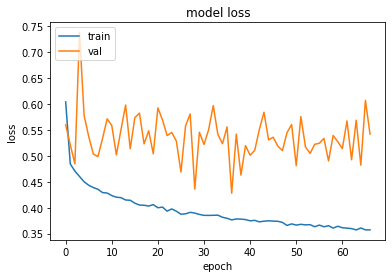

In [10]:
from sklearn.utils import class_weight
import shutil

weights = class_weight.compute_class_weight(class_weight = 'balanced',
                                            classes = np.unique(train_generator.classes),
                                            y= train_generator.classes)
weights = dict(zip(np.unique(train_generator.classes), weights))

model_name = "melanoma_ResNet50.h5"
log_dir = os.path.join(os.getcwd(), 'logs')
filepath='ResNet50.{epoch:02d}-{val_loss:.4f}.h5'
ck_path = os.path.join(log_dir, filepath)
if not os.path.isdir(log_dir):
  os.makedirs(log_dir)
mc = keras.callbacks.ModelCheckpoint(ck_path, monitor='val_loss',save_best_only=True,save_weights_only=True)
es = keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, verbose=0) # when patience epoch val_loss not improve, stop train
# tb = keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=0)
callbacks = [es, mc]

optimizer = tfa.optimizers.AdamW(learning_rate=learning_rate, weight_decay=weight_decay)
model.compile(
    optimizer=optimizer,
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics=[
        keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
        keras.metrics.SparseTopKCategoricalAccuracy(3, name="top-3-accuracy"),
    ],
)

history = model.fit(train_generator, 
                     batch_size = batch_size,
                     epochs=num_epochs,
                     use_multiprocessing=True,
                     validation_data = valid_generator,
                     callbacks=callbacks, 
                     class_weight = weights, 
                     workers=6)

model.save('resnet50_multi_final.h5') 
shutil.copy('resnet50_multi_final.h5', '/content/drive/MyDrive/melanoma_data/models')


plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [11]:
from sklearn.metrics import precision_recall_curve, auc, average_precision_score, roc_auc_score
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import PrecisionRecallDisplay



ypred = model.predict(valid_generator)
ypred = ypred.argmax(axis=-1)

precision, recall, _ = precision_recall_curve(valid_generator.labels, ypred)
print('AP:', average_precision_score(valid_generator.labels, ypred, average='macro'))
print('ROC:', roc_auc_score(valid_generator.labels, ypred))
print('AUC:', auc(recall, precision))

AP: 0.09128519859587808
ROC: 0.49434736002585755
AUC: 0.2287396953911467
